# CTC Loss with OCR

References
* https://en.wikipedia.org/wiki/Connectionist_temporal_classification
* https://keras.io/examples/vision/captcha_ocr/#model
* https://distill.pub/2017/ctc/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

try:
    DEVICE_NAME = tf.test.gpu_device_name()
    print("Found GPU at: {}".format(DEVICE_NAME))
except:
    DEVICE_NAME = "/device:CPU:0"
    print("ERROR: Not connected to a GPU runtime.")

Found GPU at: /device:GPU:0


In [2]:
# Make train-valid-test splits of images and labels.
N_train = 10000
N_valid = 2000
N_test = 2000

# Image dimensions.
height = 64
width = 256

# Character list used to create the data.
chars = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
chars = sorted([c for c in chars])

# Character to index map and reverse map.
char_to_num = tf.keras.layers.StringLookup(vocabulary = list(chars), mask_token = None)
num_to_char = tf.keras.layers.StringLookup(vocabulary = char_to_num.get_vocabulary(), mask_token = None, invert = True)

def make_data(N_samples):
    X = []
    y = []
    # Create N_samples samples of features X and labels y.
    for i in range(N_samples):
        image = np.zeros([height, width])
        # Each image contains randomly generated text with random length [4, 10].
        N = np.random.randint(4, 10 + 1)
        text = np.random.choice(chars, N)
        text = "".join(text) + (10 - len(text)) * " "
        image = cv2.putText(image, text, (32, 44), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 1, cv2.LINE_AA)
        X.append(image.reshape((height, width, 1)))
        y.append(text)
    return X, y

X_train, y_train = make_data(N_train)
X_valid, y_valid = make_data(N_valid)
X_test, y_test = make_data(N_test)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_valid = np.array(X_valid)
y_valid = np.array(y_valid)
X_test = np.array(X_test)
y_test = np.array(y_test)

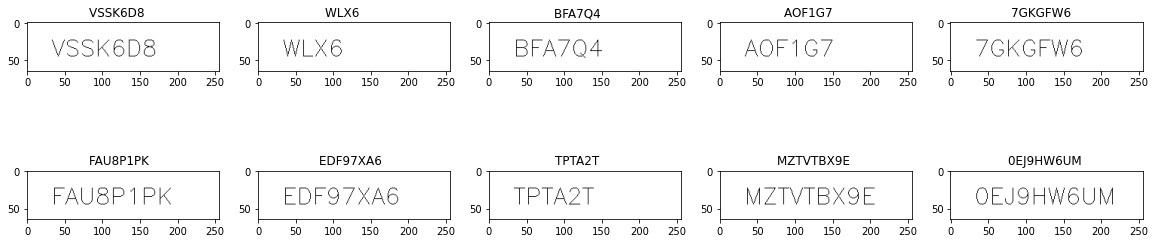

In [3]:
plt.figure(figsize = (20, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_train[i][:, :, 0], cmap = "binary")
    plt.title(y_train[i])
plt.show()

In [4]:
batch_size = 20

def encode_single_sample(X, y):
    X = tf.keras.layers.Rescaling(1.0 / 255)(X)
    X = tf.transpose(X, perm = [1, 0, 2])
    y = char_to_num(tf.strings.unicode_split(y, input_encoding = "UTF-8"))
    return {"image": X, "label": y}

with tf.device(DEVICE_NAME):
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_ds = (train_ds.map(encode_single_sample, 
                             num_parallel_calls = tf.data.AUTOTUNE).batch(batch_size).prefetch(buffer_size = tf.data.AUTOTUNE))

    valid_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
    valid_ds = (valid_ds.map(encode_single_sample, 
                             num_parallel_calls = tf.data.AUTOTUNE).batch(batch_size).prefetch(buffer_size = tf.data.AUTOTUNE))

    test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
    test_ds = (test_ds.map(encode_single_sample, 
                           num_parallel_calls = tf.data.AUTOTUNE).batch(batch_size).prefetch(buffer_size = tf.data.AUTOTUNE))

In [5]:
class CTCLayer(tf.keras.layers.Layer):
    def __init__(self, name = None):
        super().__init__(name = name)
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype = "int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype = "int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype = "int64")

        input_length = input_length * tf.ones(shape = (batch_len, 1), dtype = "int64")
        label_length = label_length * tf.ones(shape = (batch_len, 1), dtype = "int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        return y_pred


def build_model():
    input_img = tf.keras.layers.Input(shape = (width, height, 1), name = "image", dtype = "float32")
    labels = tf.keras.layers.Input(name = "label", shape = (None,), dtype = "float32")

    x = tf.keras.layers.Conv2D(32, (3, 3), activation = "relu", kernel_initializer = "he_normal",
                               padding = "same", name = "Conv1")(input_img)
    x = tf.keras.layers.MaxPooling2D((2, 2), name = "pool1")(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), activation = "relu", kernel_initializer = "he_normal",
                               padding = "same", name = "Conv2")(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), name = "pool2")(x)

    new_shape = ((width // 4), (height // 4) * 64)
    x = tf.keras.layers.Reshape(target_shape = new_shape, name = "reshape")(x)
    x = tf.keras.layers.Dense(64, activation = "relu", name = "dense1")(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences = True, dropout = 0.25))(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True, dropout = 0.25))(x)

    x = tf.keras.layers.Dense(len(char_to_num.get_vocabulary()) + 1, activation = "softmax", name = "dense2")(x)

    output = CTCLayer(name = "ctc_loss")(labels, x)

    model = tf.keras.models.Model(inputs = [input_img, labels], outputs = output, name = "ocr_model_v1")
    opt = tf.keras.optimizers.Adam()
    model.compile(optimizer = opt)
    return model


# Get the model
with tf.device(DEVICE_NAME):
    model = build_model()

print(model.summary())

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 256, 64, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 256, 64, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 128, 32, 32)  0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 128, 32, 64)  18496       ['pool1[0][0]']       

In [6]:
epochs = 20
early_stopping_patience = 10
# Add early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                                  patience = early_stopping_patience, 
                                                  restore_best_weights = True)

# Train the model
history = model.fit(train_ds, validation_data = valid_ds, epochs = epochs, callbacks = [early_stopping])

Epoch 1/20
500/500 [==============================] - 36s 50ms/step - loss: 28.0737 - val_loss: 17.1852
Epoch 2/20
500/500 [==============================] - 22s 43ms/step - loss: 4.3059 - val_loss: 0.8854
Epoch 3/20
500/500 [==============================] - 23s 46ms/step - loss: 0.9195 - val_loss: 0.7157
Epoch 4/20
500/500 [==============================] - 21s 42ms/step - loss: 0.7306 - val_loss: 0.5598
Epoch 5/20
500/500 [==============================] - 21s 41ms/step - loss: 0.4842 - val_loss: 0.0278
Epoch 6/20
500/500 [==============================] - 21s 43ms/step - loss: 0.0975 - val_loss: 0.0097
Epoch 7/20
500/500 [==============================] - 26s 53ms/step - loss: 0.0459 - val_loss: 0.0171
Epoch 8/20
500/500 [==============================] - 21s 41ms/step - loss: 0.0448 - val_loss: 0.0044
Epoch 9/20
500/500 [==============================] - 21s 41ms/step - loss: 0.0232 - val_loss: 0.0112
Epoch 10/20
500/500 [==============================] - 21s 42ms/step - loss: 0.0

In [7]:
# Get the prediction model by extracting layers till the output layer
prediction_model = tf.keras.models.Model(model.get_layer(name = "image").input, model.get_layer(name = "dense2").output)
prediction_model.summary()

max_length = 10

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = tf.keras.backend.ctc_decode(pred, input_length = input_len, greedy = True)[0][0][:, :max_length]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 256, 64, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 256, 64, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 128, 32, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 128, 32, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 64, 16, 64)        0         
                                                                 
 reshape (Reshape)           (None, 64, 1024)          0         
                                                                 
 dense1 (Dense)              (None, 64, 64)            65600 

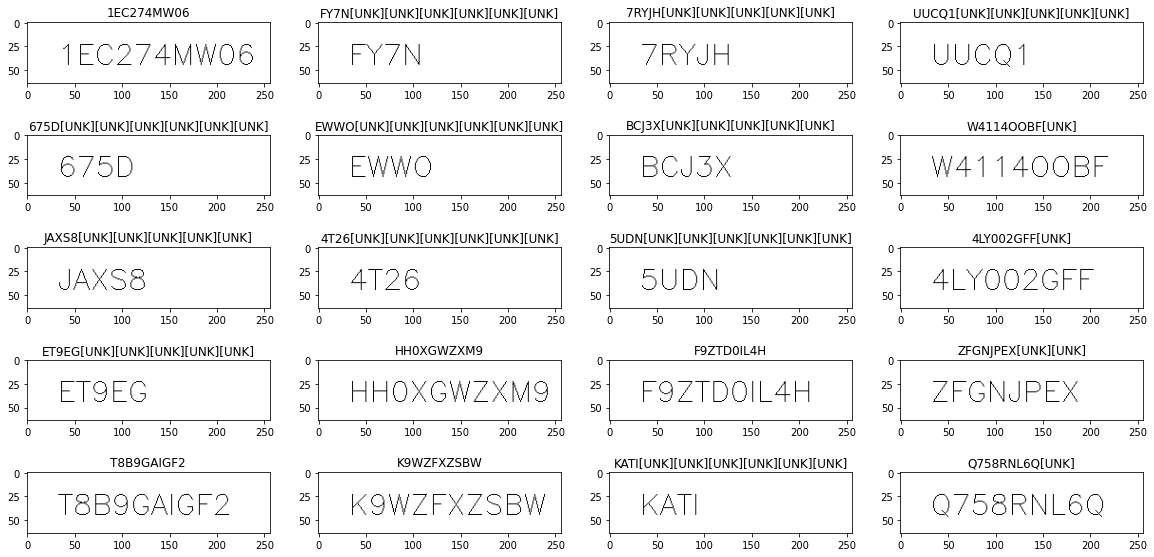

In [8]:
for batch in test_ds.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(5, 4, figsize = (20, 10))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = "{}".format(pred_texts[i])
        ax[i // 4, i % 4].imshow(img, cmap = "binary")
        ax[i // 4, i % 4].set_title(title)
plt.show()